# Project data

MODIS based:
CHL (modis)
SST (modis)
PAR (modis)

SEAWIFS based:
CHL (seawifs)
SST (avhrr)
PAR (seawifs)

#### The data for SST, PAR, Chl, Salinity, DO, N, P are downloaded from websites and decompressed.

#### I only keep the files after decompression.

#### https://mixedlayer.ucsd.edu/

#### https://sites.science.oregonstate.edu/ocean.productivity/2160.by.4320.8day.inputData.php

#### https://www.ncei.noaa.gov/access/world-ocean-atlas-2023/

#### The data for iron(Fe) is newly added here as a variable, in addition to Tang(2019)'s paper.

#### https://zenodo.org/records/6994318

### 1. Draw the samples of the variables

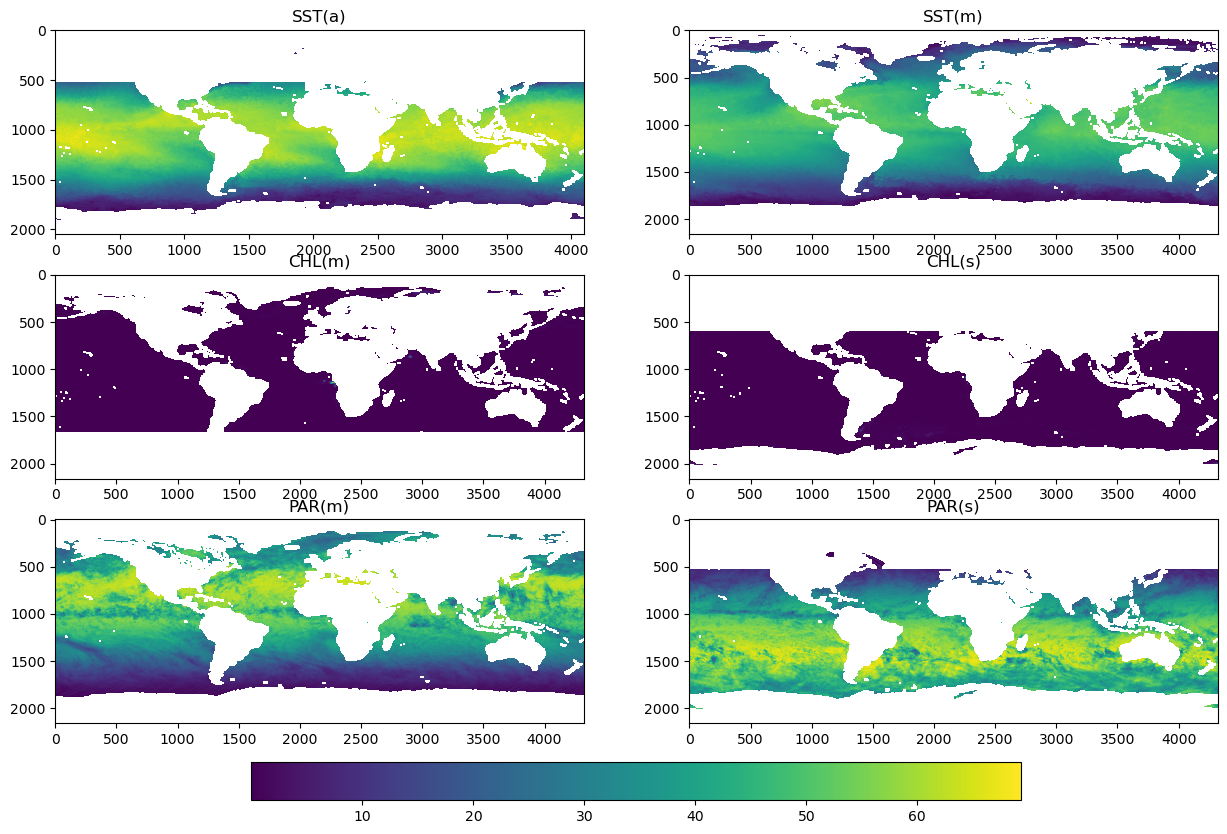

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
files = [
    "SST(a)/sst.2009361.hdf.mat",
    "SST(m)/sst.2023209.hdf.mat",
    "CHL(m)/chl.2023209.hdf.mat",
    "CHL(s)/chl.2010337.hdf.mat",
    "PAR(m)/par.2023209.hdf.mat",
    "PAR(s)/par.2010337.hdf.mat"
]

# Titles for the plots
titles = ["SST(a)", "SST(m)", "CHL(m)", "CHL(s)", "PAR(m)", "PAR(s)"]

fig, axes = plt.subplots(3, 2, figsize=(15, 10))

for i, ax in enumerate(axes.flat):
    # Load data
    data = loadmat(files[i])['dt']
    #sst_data[sst_data < -3] = np.nan  # Remove invalid values

    im = ax.imshow(data, aspect='auto')
    ax.set_title(titles[i])
    #ax.axis("off")  # Remove axis ticks
cbar = fig.colorbar(im, ax=axes, orientation='horizontal', fraction=0.05, pad=0.05)

#plt.tight_layout()
plt.savefig("variables_image.png", dpi=300, bbox_inches='tight')
plt.show()


### 2. Calculate euphotic depth

In [7]:
import pandas as pd
import numpy as np

def euphotic_depth(chl):
    chl_tot = 40.2 * np.power(chl, 0.507)
    index = chl < 1.0
    chl_tot[index] = 38.0 * np.power(chl[index], 0.425)
    
    z_eu = 200.0 * np.power(chl_tot, -0.293)
    index = z_eu <= 102.0
    z_eu[index] = 568.2 * np.power(chl_tot[index], -0.746)
    
    return z_eu

### 3. Match the variables to the dataset

#### 3.1 Match SST(m)

In [8]:
from scipy.io import loadmat
import glob
import pandas as pd
import numpy as np

# 1. path
sst_m_path = "SST(m)"

# 2. Convert DATE from observations
# to 8-day unit used by satellite data.
# -------------- #
dt = pd.read_excel("2023-Shao et al-DiazotrophsDatabase-20230626.xlsx", 
                   'N2_Fixation_Integral (24 h)')
dt = dt.assign(DATE_str=lambda x: x['DATE (yyyy-mm-dd)'].astype(str).str.slice(0,10))\
       .assign(DATE=lambda x: pd.to_datetime(x['DATE_str']))\
       .assign(YRDY=lambda x: x['DATE'].dt.dayofyear - 1)\
       .assign(YRDY=lambda x: (x['YRDY']/8).astype('int') * 8 + 1)\
       .assign(YRSTR=lambda x: x['DATE'].dt.year.astype('str'),
               YRDY_STR=lambda x: x['YRDY'].astype('str').str.rjust(3,'0'),
               YRDY=lambda x: x['YRSTR'] + x['YRDY_STR']
              )\
       .drop(columns=['YRSTR', 'YRDY_STR'])

# -------------- #

# 3. To ease repeatly loading data,
# match data with the same date together
# -------------- #
for yrdy in dt['YRDY'].unique():
    # 3.1. load CHL
    #print(yrdy)
    sst_fname = glob.glob(sst_m_path + "/sst." + yrdy + ".hdf.mat")
    if len(sst_fname) == 0:
        continue
    #print(sst_fname[0])
   
    sst_m = loadmat(sst_fname[0])['dt']
    sst_m[sst_m<-3] = np.nan
    #print(sst.shape)
   
    # 3.2. Lat and Lon
    itv = 180 / sst_m.shape[0]
    sst_lat = np.linspace(90-itv/2, -90+itv/2, sst_m.shape[0])[np.newaxis,:]
    sst_lon = np.linspace(-180+itv/2, 180-itv/2, sst_m.shape[1])[np.newaxis,:]
   
    # 3.3. Match CHL
    idx = dt["YRDY"] == yrdy
    i = np.abs(dt.loc[idx,"LATITUDE"].to_numpy()[:,np.newaxis] - sst_lat).argmin(axis=1)
    j = np.abs(dt.loc[idx,"LONGITUDE"].to_numpy()[:,np.newaxis] - sst_lon).argmin(axis=1)
    dt.loc[idx,"SST(m)"] = sst_m[i, j]

In [9]:
dt

,SOURCE: Related article or authors,METHODS: Sampling/Analysis,Incubation Time (hour),DATE (yyyy-mm-dd),LATITUDE,LONGITUDE,DEPTH (m),Trichodesmium N2 Fixation (μmol N m-2 d-1),Heterocyst N2 Fixation (μmol N m-2 d-1),< 10 μm N2 Fixation (μmol N m-2 d-1),...,Near-surface Salinity (PSU),Near-surface Nitrate (µM),Near-surface Phosphate (µM),Near-surface Fe (nM),Near-surface Chlorophyll-a (mg m-3),Notes,DATE_str,DATE,YRDY,SST(m)
0,"Bonnet et al. (2009), doi:10.1029/2008GB003439",15N2 bubble assimilation,24,2006-08-26 00:00:00,0.004301,-140.0006,100.0,NaN,NaN,97.486084,...,4.32,0.49,NaN,NaN,23.671177,NaN,2006-08-26,2006-08-26,2006233,26.324999
1,NaN,15N2 bubble assimilation,24,2006-08-21 00:00:00,0.000997,-154.9999,80.0,NaN,NaN,23.092953,...,3.55,0.5,NaN,NaN,19.618742,NaN,2006-08-21,2006-08-21,2006233,27.545000
2,NaN,15N2 bubble assimilation,24,2006-06-09 00:00:00,0.005524,-170.0002,120.0,NaN,NaN,106.908211,...,0.47,0.23,NaN,NaN,21.232935,NaN,2006-06-09,2006-06-09,2006153,28.320000
3,NaN,15N2 bubble assimilation,24,2006-10-09 00:00:00,0.001257,179.9993,145.0,NaN,NaN,176.333235,...,0.02,0.25,NaN,NaN,37.18997,NaN,2006-10-09,2006-10-09,2006281,30.224998
4,NaN,15N2 bubble assimilation,24,2006-06-09 00:00:00,-0.000277,165.0018,150.0,NaN,NaN,58.252928,...,0.08,0.03,NaN,NaN,14.848673,NaN,2006-06-09,2006-06-09,2006153,30.429998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1784,NaN,15N2 bubble assimilation,24,2016-01-02 00:00:00,11.000000,143.0000,100.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2016-01-02,2016-01-02,2016001,27.684999
1785,NaN,15N2 bubble assimilation,24,2015-07-05 00:00:00,18.000000,110.0000,44.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2015-07-05,2015-07-05,2015185,29.154999
1786,NaN,15N2 bubble assimilation,24,2015-07-05 00:00:00,18.000000,110.5000,25.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2015-07-05,2015-07-05,2015185,30.545000
1787,NaN,15N2 bubble assimilation,24,2015-07-06 00:00:00,18.000000,112.5000,50.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2015-07-06,2015-07-06,2015185,30.285000


#### 3.1 Match SST(a)

In [10]:
sst_a_path = r"SST(a)"

for yrdy in dt['YRDY'].unique():
    sst_a_fname = glob.glob(sst_a_path + "/sst." + yrdy + ".hdf.mat")
    if len(sst_a_fname) == 0:
        continue
    sst_a = loadmat(sst_a_fname[0])['dt']
    sst_a[sst_a < -3] = np.nan
    
    itv = 180 / sst_a.shape[0]
    sst_lat = np.linspace(90-itv/2, -90+itv/2, sst_a.shape[0])[np.newaxis,:]
    sst_lon = np.linspace(-180+itv/2, 180-itv/2, sst_a.shape[1])[np.newaxis,:]
   
    # 3.3. Match SST
    idx = dt["YRDY"] == yrdy
    i = np.abs(dt.loc[idx,"LATITUDE"].to_numpy()[:,np.newaxis] - sst_lat).argmin(axis=1)
    j = np.abs(dt.loc[idx,"LONGITUDE"].to_numpy()[:,np.newaxis] - sst_lon).argmin(axis=1)
    dt.loc[idx,"SST(a)"] = sst_a[i, j]

In [11]:
dt

,SOURCE: Related article or authors,METHODS: Sampling/Analysis,Incubation Time (hour),DATE (yyyy-mm-dd),LATITUDE,LONGITUDE,DEPTH (m),Trichodesmium N2 Fixation (μmol N m-2 d-1),Heterocyst N2 Fixation (μmol N m-2 d-1),< 10 μm N2 Fixation (μmol N m-2 d-1),...,Near-surface Nitrate (µM),Near-surface Phosphate (µM),Near-surface Fe (nM),Near-surface Chlorophyll-a (mg m-3),Notes,DATE_str,DATE,YRDY,SST(m),SST(a)
0,"Bonnet et al. (2009), doi:10.1029/2008GB003439",15N2 bubble assimilation,24,2006-08-26 00:00:00,0.004301,-140.0006,100.0,NaN,NaN,97.486084,...,0.49,NaN,NaN,23.671177,NaN,2006-08-26,2006-08-26,2006233,26.324999,26.287500
1,NaN,15N2 bubble assimilation,24,2006-08-21 00:00:00,0.000997,-154.9999,80.0,NaN,NaN,23.092953,...,0.5,NaN,NaN,19.618742,NaN,2006-08-21,2006-08-21,2006233,27.545000,27.937502
2,NaN,15N2 bubble assimilation,24,2006-06-09 00:00:00,0.005524,-170.0002,120.0,NaN,NaN,106.908211,...,0.23,NaN,NaN,21.232935,NaN,2006-06-09,2006-06-09,2006153,28.320000,28.500002
3,NaN,15N2 bubble assimilation,24,2006-10-09 00:00:00,0.001257,179.9993,145.0,NaN,NaN,176.333235,...,0.25,NaN,NaN,37.18997,NaN,2006-10-09,2006-10-09,2006281,30.224998,29.325001
4,NaN,15N2 bubble assimilation,24,2006-06-09 00:00:00,-0.000277,165.0018,150.0,NaN,NaN,58.252928,...,0.03,NaN,NaN,14.848673,NaN,2006-06-09,2006-06-09,2006153,30.429998,29.381250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1784,NaN,15N2 bubble assimilation,24,2016-01-02 00:00:00,11.000000,143.0000,100.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2016-01-02,2016-01-02,2016001,27.684999,NaN
1785,NaN,15N2 bubble assimilation,24,2015-07-05 00:00:00,18.000000,110.0000,44.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2015-07-05,2015-07-05,2015185,29.154999,NaN
1786,NaN,15N2 bubble assimilation,24,2015-07-05 00:00:00,18.000000,110.5000,25.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2015-07-05,2015-07-05,2015185,30.545000,NaN
1787,NaN,15N2 bubble assimilation,24,2015-07-06 00:00:00,18.000000,112.5000,50.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2015-07-06,2015-07-06,2015185,30.285000,NaN


#### 3.2 Match CHL(m) and CHL(s)

In [12]:
chl_m_path = r"CHL(m)"
for yrdy in dt['YRDY'].unique():
    #CHL(m)
    chl_m_fname = glob.glob(chl_m_path + "/chl." + yrdy + ".hdf.mat")
    if len(chl_m_fname) == 0:
        continue
    chl_m = loadmat(chl_m_fname[0])['dt']
    chl_m[chl_m < -3] = np.nan
    
    itv = 180 / chl_m.shape[0]
    chl_lat = np.linspace(90-itv/2, -90+itv/2, chl_m.shape[0])[np.newaxis,:]
    chl_lon = np.linspace(-180+itv/2, 180-itv/2, chl_m.shape[1])[np.newaxis,:]
    
    idx = dt["YRDY"] == yrdy
    i = np.abs(dt.loc[idx, "LATITUDE"].to_numpy()[:, np.newaxis] - chl_lat).argmin(axis=1)
    j = np.abs(dt.loc[idx, "LONGITUDE"].to_numpy()[:, np.newaxis] - chl_lon).argmin(axis=1)
    dt.loc[idx, "CHL(m)"] = chl_m[i, j]

In [13]:
chl_s_path = r"CHL(s)"
for yrdy in dt['YRDY'].unique():  
    #CHL(s)
    chl_s_fname = glob.glob(chl_s_path + "/chl." + yrdy + ".hdf.mat")
    if len(chl_s_fname) == 0:
        continue
    chl_s = loadmat(chl_s_fname[0])['dt']
    chl_s[chl_s < -3] = np.nan
    
    itv = 180 / chl_m.shape[0]
    chl_lat = np.linspace(90-itv/2, -90+itv/2, chl_s.shape[0])[np.newaxis,:]
    chl_lon = np.linspace(-180+itv/2, 180-itv/2, chl_s.shape[1])[np.newaxis,:]
    
    idx = dt["YRDY"] == yrdy
    i = np.abs(dt.loc[idx, "LATITUDE"].to_numpy()[:, np.newaxis] - chl_lat).argmin(axis=1)
    j = np.abs(dt.loc[idx, "LONGITUDE"].to_numpy()[:, np.newaxis] - chl_lon).argmin(axis=1)
    dt.loc[idx, "CHL(s)"] = chl_s[i, j]

#### 3.3 Match PAR(m) and PAR(s)

In [15]:
par_m_path = r"PAR(m)"
for yrdy in dt['YRDY'].unique():
    #par(m)
    par_m_fname = glob.glob(par_m_path + "/par." + yrdy + ".hdf.mat")
    if len(par_m_fname) == 0:
        continue
    par_m = loadmat(par_m_fname[0])['dt']
    #par_m[par_m < -3] = np.nan
    
    itv = 180 / par_m.shape[0]
    par_lat = np.linspace(90-itv/2, -90+itv/2, par_m.shape[0])[np.newaxis,:]
    par_lon = np.linspace(-180+itv/2, 180-itv/2, par_m.shape[1])[np.newaxis,:]
    
    idx = dt["YRDY"] == yrdy
    i = np.abs(dt.loc[idx, "LATITUDE"].to_numpy()[:, np.newaxis] - par_lat).argmin(axis=1)
    j = np.abs(dt.loc[idx, "LONGITUDE"].to_numpy()[:, np.newaxis] - par_lon).argmin(axis=1)
    dt.loc[idx, "PAR(m)"] = par_m[i, j]

In [16]:
par_s_path = r"PAR(s)"
for yrdy in dt['YRDY'].unique():
    #par(s)
    par_s_fname = glob.glob(par_s_path + "/par." + yrdy + ".hdf.mat")
    if len(par_s_fname) == 0:
        continue
    par_s = loadmat(par_s_fname[0])['dt']
    #par_s[par_s < -3] = np.nan
    
    itv = 180 / par_s.shape[0]
    par_lat = np.linspace(90-itv/2, -90+itv/2, par_s.shape[0])[np.newaxis,:]
    par_lon = np.linspace(-180+itv/2, 180-itv/2, par_s.shape[1])[np.newaxis,:]
    
    idx = dt["YRDY"] == yrdy
    i = np.abs(dt.loc[idx, "LATITUDE"].to_numpy()[:, np.newaxis] - par_lat).argmin(axis=1)
    j = np.abs(dt.loc[idx, "LONGITUDE"].to_numpy()[:, np.newaxis] - par_lon).argmin(axis=1)
    dt.loc[idx, "PAR(s)"] = par_s[i, j]

#### 3.4 Match MLD

In [17]:
from scipy.io import loadmat

mld = loadmat('Argo_mixedlayers_monthlyclim_04142022.mat')
dt['MLD'] = np.nan

for mn_idx in range(0, 12):
    # Match month with 'Date' column in 'dt' DataFrame
    idxes = dt.index[dt['DATE'].dt.month == (mn_idx + 1)]

    if len(idxes) > 0:
        # Find closest latitude and longitude values
        # print(dt_csv.columns)
        for idx in idxes:
            lat = dt.loc[idx, 'LATITUDE']
            lon = dt.loc[idx, 'LONGITUDE']
            lat_idx = np.abs(mld['latm'][0] - lat).argmin()
            lon_idx = np.abs(mld['lonm'][:,0] - lon).argmin()
            dt.loc[idx, 'MLD'] = mld['mld_dt_mean'][mn_idx, lon_idx, lat_idx]

#### Calculate "CHL" "PAR" "SST" columns

In [23]:
dt['CHL'] = np.nanmean([dt['CHL(m)'], dt['CHL(s)']], axis=0)

/opt/anaconda3/envs/pymc_env/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.


In [24]:
dt['SST'] = np.nanmean([dt['SST(m)'], dt['SST(a)']], axis=0)
dt['PAR'] = np.nanmean([dt['PAR(m)'], dt['PAR(s)']], axis=0)

/opt/anaconda3/envs/pymc_env/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.
/opt/anaconda3/envs/pymc_env/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  


In [25]:
dt

,SOURCE: Related article or authors,METHODS: Sampling/Analysis,Incubation Time (hour),DATE (yyyy-mm-dd),LATITUDE,LONGITUDE,DEPTH (m),Trichodesmium N2 Fixation (μmol N m-2 d-1),Heterocyst N2 Fixation (μmol N m-2 d-1),< 10 μm N2 Fixation (μmol N m-2 d-1),...,SST(m),SST(a),CHL(m),CHL(s),PAR(m),PAR(s),MLD,CHL,SST,PAR
0,"Bonnet et al. (2009), doi:10.1029/2008GB003439",15N2 bubble assimilation,24,2006-08-26 00:00:00,0.004301,-140.0006,100.0,NaN,NaN,97.486084,...,26.324999,26.287500,0.201787,0.293211,55.531998,55.709999,38.735352,0.247499,26.306250,55.620998
1,NaN,15N2 bubble assimilation,24,2006-08-21 00:00:00,0.000997,-154.9999,80.0,NaN,NaN,23.092953,...,27.545000,27.937502,0.204105,0.210049,55.433998,54.135998,39.282626,0.207077,27.741251,54.784996
2,NaN,15N2 bubble assimilation,24,2006-06-09 00:00:00,0.005524,-170.0002,120.0,NaN,NaN,106.908211,...,28.320000,28.500002,0.208920,0.192897,49.998001,50.644001,37.056858,0.200909,28.410000,50.320999
3,NaN,15N2 bubble assimilation,24,2006-10-09 00:00:00,0.001257,179.9993,145.0,NaN,NaN,176.333235,...,30.224998,29.325001,0.095121,0.095136,56.903999,57.107998,39.290532,0.095128,29.775000,57.005997
4,NaN,15N2 bubble assimilation,24,2006-06-09 00:00:00,-0.000277,165.0018,150.0,NaN,NaN,58.252928,...,30.429998,29.381250,0.137850,0.188577,43.023998,45.329998,38.530601,0.163214,29.905624,44.176998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1784,NaN,15N2 bubble assimilation,24,2016-01-02 00:00:00,11.000000,143.0000,100.0,NaN,NaN,NaN,...,27.684999,NaN,0.062274,NaN,45.141998,NaN,65.912825,0.062274,27.684999,45.141998
1785,NaN,15N2 bubble assimilation,24,2015-07-05 00:00:00,18.000000,110.0000,44.0,NaN,NaN,NaN,...,29.154999,NaN,0.155764,NaN,55.074001,NaN,NaN,0.155764,29.154999,55.074001
1786,NaN,15N2 bubble assimilation,24,2015-07-05 00:00:00,18.000000,110.5000,25.0,NaN,NaN,NaN,...,30.545000,NaN,0.143618,NaN,54.743999,NaN,NaN,0.143618,30.545000,54.743999
1787,NaN,15N2 bubble assimilation,24,2015-07-06 00:00:00,18.000000,112.5000,50.0,NaN,NaN,NaN,...,30.285000,NaN,0.090397,NaN,51.071999,NaN,26.062134,0.090397,30.285000,51.071999


#### 3.5 Match Salinity, DO 

In [27]:
salinity_folder = r"Salinity"
dt['Salinity'] = np.nan

for month_num in range(1, 13):
    # Read CSV file
    csv_file = salinity_folder + "/woa23_decav_s" + str(month_num).rjust(2,'0') + "mn01.csv"
    if len(csv_file) == 0:
        continue   
    #print(csv_file)
    
    dt_csv = pd.read_csv(csv_file, skiprows=1)
    #print(dt_csv.shape)
    
    # Match month with 'Date' column in 'dt' DataFrame
    # find the index
    idxes = dt.index[dt['DATE'].dt.month == month_num]

    if len(idxes) > 0:
        # Find closest latitude and longitude values
        #print(dt_csv.columns)
        for idx in idxes:
            lat = dt.loc[idx, 'LATITUDE']
            lon = dt.loc[idx, 'LONGITUDE']
            closest_point = dt_csv.iloc[((dt_csv['#COMMA SEPARATED LATITUDE'] - lat)**2 + 
                                         (dt_csv[' LONGITUDE'] - lon)**2).idxmin()]
            salinity_value = closest_point[' AND VALUES AT DEPTHS (M):0']

            # Step 4: Add salinity value to 'dt' DataFrame
            dt.loc[idx, 'Salinity'] = salinity_value
            

#### Dissovled Oxygen:取 0-500m最小值, np.nanmin(dt, axis=1)

In [28]:
dissolved_oxygen_folder = r"DO"
dt['DO'] = np.nan

for month_num in range(1, 13):
    
    # Read CSV file
    csv_file = dissolved_oxygen_folder + "/woa23_all_o" + str(month_num).rjust(2,'0') + "mn01.csv"
    if len(csv_file) == 0:
        continue
    
    #print(csv_file)
    
    dt_csv = pd.read_csv(csv_file, skiprows=1)
    #print(dt_csv.shape)
    
    # Match month with 'Date' column in 'dt' DataFrame
    idxes = dt.index[dt['DATE'].dt.month == month_num]

    if len(idxes) > 0:
        # Find closest latitude and longitude values
        # print(dt_csv.columns)
        for idx in idxes:
            lat = dt.loc[idx, 'LATITUDE']
            lon = dt.loc[idx, 'LONGITUDE']
            
            closest_point = dt_csv.iloc[((dt_csv['#COMMA SEPARATED LATITUDE'] - lat)**2 + 
                                         (dt_csv[' LONGITUDE'] - lon)**2).idxmin()]
            
            # store all the columns within depth = 500
            relevant_columns = closest_point.loc[' AND VALUES AT DEPTHS (M):0' : '500']
            dissolved_oxygen_value = np.nanmin(relevant_columns)

            dt.loc[idx, 'DO'] = dissolved_oxygen_value

#### 3.6 Match P, N (use the average value within euphotic depth

In [29]:
# calculate the euphotic depth of the data in the dataset
dt['z_eu'] = euphotic_depth(dt['CHL'].values)

In [30]:
dt['z_eu'].describe()

count    1742.000000
mean       65.260559
std        26.686411
min         7.144379
25%        42.463432
50%        65.257591
75%        88.377060
max       124.274467
Name: z_eu, dtype: float64

#### Nitrate

In [31]:
Nitrate_folder = r"N"
dt['N_avg'] = np.nan

for month_num in range(1, 13):
    csv_file = Nitrate_folder + "/woa23_all_n" + str(month_num).rjust(2,'0') + "mn01.csv"
    if len(csv_file) == 0:
        continue   
    #print(csv_file)
    
    dt_csv = pd.read_csv(csv_file, skiprows=1)
    #print(dt_csv.shape)
    
    # Match month with 'Date' column in 'dt' DataFrame
    # find the index
    idxes = dt.index[dt['DATE'].dt.month == month_num]

    if len(idxes) > 0:
        
        for idx in idxes:
            lat = dt.loc[idx, 'LATITUDE']
            lon = dt.loc[idx, 'LONGITUDE']
            z_eu = dt.loc[idx, 'z_eu']
            
            # Find closest latitude and longitude values 
            # the closest point in the nitrate data
            closest_point = dt_csv.iloc[((dt_csv['#COMMA SEPARATED LATITUDE'] - lat)**2 + 
                                         (dt_csv[' LONGITUDE'] - lon)**2).idxmin()]
            
            # Extract nitrate values up to the euphotic depth
            depths = np.array([0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 125])
            nitrate_values = []

            for depth in depths:
                if depth == 0:
                    nitrate_column = ' AND VALUES AT DEPTHS (M):0'   # different column name when depth=0
                if depth != 0 and depth <= z_eu:
                    nitrate_column = f'{depth}'
                
                nitrate_value = closest_point.get(nitrate_column, np.nan) # returning NaN if the column is not found.
                if not np.isnan(nitrate_value):
                        nitrate_values.append(nitrate_value)
                
           
            # Calculate the average N within the euphotic depth
            if nitrate_values:
                avg_nitrate = np.nanmean(nitrate_values)
                dt.loc[idx, 'N_avg'] = avg_nitrate
            else:
                dt.loc[idx, 'N_avg'] = np.nan

#### Phosphate

In [35]:
Phosphate_folder = r"P"
dt['P_avg'] = np.nan

for month_num in range(1, 13):
    # Read CSV file
    csv_file = Phosphate_folder + "/woa23_all_p" + str(month_num).rjust(2,'0') + "mn01.csv"
    if len(csv_file) == 0:
        continue
    print(csv_file)
    
    dt_csv = pd.read_csv(csv_file, skiprows=1)
    print(dt_csv.shape)
    
    # Match month with 'Date' column in 'dt' DataFrame
    # find the index
    idxes = dt.index[dt['DATE'].dt.month == month_num]

    if len(idxes) > 0:
        
        for idx in idxes:
            lat = dt.loc[idx, 'LATITUDE']
            lon = dt.loc[idx, 'LONGITUDE']
            z_eu = dt.loc[idx, 'z_eu']
            
            # Find closest latitude and longitude values 
            # the closest point in the nitrate data
            closest_point = dt_csv.iloc[((dt_csv['#COMMA SEPARATED LATITUDE'] - lat)**2 + 
                                         (dt_csv[' LONGITUDE'] - lon)**2).idxmin()]
            
            # Extract nitrate values up to the euphotic depth
            depths = np.array([0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 125])
            Phosphate_values = []

            for depth in depths:
                if depth == 0:
                    Phosphate_column = ' AND VALUES AT DEPTHS (M):0'   # different column name when depth=0
                if depth != 0 and depth <= z_eu:
                    Phosphate_column = f'{depth}'
                
                Phosphate_value = closest_point.get(Phosphate_column, np.nan) # returning NaN if the column is not found.
                if not np.isnan(Phosphate_value):
                    Phosphate_values.append(Phosphate_value)
                
            # Calculate the average nitrate concentration within the euphotic depth
            if Phosphate_values:
                avg_Phosphate = np.nanmean(Phosphate_values)
                dt.loc[idx, 'P_avg'] = avg_Phosphate
            else:
                dt.loc[idx, 'P_avg'] = np.nan


P/woa23_all_p01mn01.csv
(5390, 39)
P/woa23_all_p02mn01.csv
(6077, 39)
P/woa23_all_p03mn01.csv
(5908, 39)
P/woa23_all_p04mn01.csv
(5784, 39)
P/woa23_all_p05mn01.csv
(5484, 39)
P/woa23_all_p06mn01.csv
(5390, 39)
P/woa23_all_p07mn01.csv
(5828, 39)
P/woa23_all_p08mn01.csv
(6201, 39)
P/woa23_all_p09mn01.csv
(5520, 39)
P/woa23_all_p10mn01.csv
(4878, 39)
P/woa23_all_p11mn01.csv
(4576, 39)
P/woa23_all_p12mn01.csv
(4059, 39)


In [44]:
dt

,SOURCE: Related article or authors,METHODS: Sampling/Analysis,Incubation Time (hour),DATE (yyyy-mm-dd),LATITUDE,LONGITUDE,DEPTH (m),Trichodesmium N2 Fixation (μmol N m-2 d-1),Heterocyst N2 Fixation (μmol N m-2 d-1),< 10 μm N2 Fixation (μmol N m-2 d-1),...,PAR(s),MLD,CHL,SST,PAR,Salinity,DO,z_eu,N_avg,P_avg
0,"Bonnet et al. (2009), doi:10.1029/2008GB003439",15N2 bubble assimilation,24,2006-08-26 00:00:00,0.004301,-140.0006,100.0,NaN,NaN,97.486084,...,55.709999,38.735352,0.247499,26.306250,55.620998,35.010,32.179,58.647629,6.505273,0.567727
1,NaN,15N2 bubble assimilation,24,2006-08-21 00:00:00,0.000997,-154.9999,80.0,NaN,NaN,23.092953,...,54.135998,39.282626,0.207077,27.741251,54.784996,35.240,31.600,62.058765,1.092053,0.323579
2,NaN,15N2 bubble assimilation,24,2006-06-09 00:00:00,0.005524,-170.0002,120.0,NaN,NaN,106.908211,...,50.644001,37.056858,0.200909,28.410000,50.320999,35.333,53.664,62.656601,3.741100,0.431500
3,NaN,15N2 bubble assimilation,24,2006-10-09 00:00:00,0.001257,179.9993,145.0,NaN,NaN,176.333235,...,57.107998,39.290532,0.095128,29.775000,57.005997,35.200,58.496,79.416245,0.018550,0.136182
4,NaN,15N2 bubble assimilation,24,2006-06-09 00:00:00,-0.000277,165.0018,150.0,NaN,NaN,58.252928,...,45.329998,38.530601,0.163214,29.905624,44.176998,35.010,144.204,66.923416,1.891727,0.153182
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1784,NaN,15N2 bubble assimilation,24,2016-01-02 00:00:00,11.000000,143.0000,100.0,NaN,NaN,NaN,...,NaN,65.912825,0.062274,27.684999,45.141998,34.363,67.338,90.834015,0.781000,0.053143
1785,NaN,15N2 bubble assimilation,24,2015-07-05 00:00:00,18.000000,110.0000,44.0,NaN,NaN,NaN,...,NaN,NaN,0.155764,29.154999,55.074001,33.711,145.403,67.922020,0.079727,0.385136
1786,NaN,15N2 bubble assimilation,24,2015-07-05 00:00:00,18.000000,110.5000,25.0,NaN,NaN,NaN,...,NaN,NaN,0.143618,30.545000,54.743999,33.883,129.913,69.693031,0.079727,0.385136
1787,NaN,15N2 bubble assimilation,24,2015-07-06 00:00:00,18.000000,112.5000,50.0,NaN,NaN,NaN,...,NaN,26.062134,0.090397,30.285000,51.071999,33.670,97.011,80.711334,0.177136,0.463409


In [45]:
dt.to_excel("data.xlsx", index=False)

### 4. Add variable iron(Fe)

#### Decompress the files and convert into csv

In [4]:
import pandas as pd
import numpy as np
import netCDF4 as nc
import xarray as xr
import matplotlib.pyplot as plt

file_path = 'Monthly_dFe_V2.nc'
dataset = nc.Dataset(file_path, 'r')
dataset

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format NETCDF3):
    Month_dFe_V2: This version interpolates to a greater degree, thereby filling missing values in some coastal regions and open ocean
    Author: Yibin Huang & Nicolas Cassar
    Correspond: nicolas.cassar@duke.edu
    Request_for_citation: If you use these data in publications or presentations, please cite: Huang, Y.,Tagliabue, A., & Cassar, N. (2022). Data-driven modeling of dissolved iron in the global ocean. Frontier in Marine Science
    Creation date: Aug/4th/2022
    dimensions(sizes): Longitude(360), Latitude(147), Depth(31), Month(13)
    variables(dimensions): float64 Longitude(Longitude), float64 Latitude(Latitude), float64 Depth(Depth), float64 Month(Month), float64 dFe_RF(Month, Depth, Latitude, Longitude)
    groups: 

In [6]:
print(dataset.variables.keys())

dict_keys(['Longitude', 'Latitude', 'Depth', 'Month', 'dFe_RF'])


In [8]:
depth_var = dataset.variables['Depth']
depth_values = depth_var[:]
depth_values

masked_array(data=[  11.        ,   25.00021076,   35.00164032,
                     45.00521088,   55.01295471,   65.02882767,
                     75.06052399,   85.1230545 ,   95.2456131 ,
                    105.48506165,  115.95201111,  126.86147308,
                    138.6305542 ,  152.0652771 ,  168.71194458,
                    191.4947052 ,  225.79350281,  281.00210571,
                    371.99203491,  518.41903687,  738.76904297,
                   1040.19091797, 1413.5045166 , 1839.50756836,
                   2298.97729492, 2777.81152344, 3267.25073242,
                   3762.32299805, 4260.33935547, 4759.88134766,
                   5260.21044922],
             mask=False,
       fill_value=1e+20)

In [17]:
# 31 depths
depths = [
    11.000000000000002, 25.000210762023926, 35.00164031982422, 45.005210876464844, 
    55.01295471191406, 65.02882766723634, 75.06052398681639, 85.12305450439452, 
    95.24561309814453, 105.48506164550784, 115.95201110839845, 126.8614730834961, 
    138.63055419921872, 152.06527709960943, 168.71194458007818, 191.49470520019523, 
    225.7935028076171, 281.0021057128906, 371.9920349121094, 518.4190368652341, 
    738.7690429687499, 1040.1909179687498, 1413.5045166015623, 1839.5075683593748, 
    2298.977294921875, 2777.8115234374995, 3267.2507324218755, 3762.3229980468723, 
    4260.339355468752, 4759.881347656251, 5260.210449218748
]


In [10]:
# Extract variables
lon_values = dataset.variables['Longitude'][:]
lat_values = dataset.variables['Latitude'][:]
depth_values = dataset.variables['Depth'][:]
month_values = dataset.variables['Month'][:]
dfe_rf_values = dataset.variables['dFe_RF'][:]

# Verify the shapes
print(f"Shape of dFe_RF: {dfe_rf_values.shape}")
print(f"Length of lon_values: {len(lon_values)}")
print(f"Length of lat_values: {len(lat_values)}")
print(f"Length of depth_values: {len(depth_values)}")
print(f"Length of month_values: {len(month_values)}")

Shape of dFe_RF: (13, 31, 147, 360)
Length of lon_values: 360
Length of lat_values: 147
Length of depth_values: 31
Length of month_values: 13


In [12]:
# Iterate over each month and save data to CSV
for month_idx in range(12):
    results = []
    for lon_idx in range(len(lon_values)):
        for lat_idx in range(len(lat_values)):
            for depth_idx in range(len(depth_values)):
                fe_value = dfe_rf_values[month_idx, depth_idx, lat_idx, lon_idx]
                results.append({
                    'month': month_values[month_idx],
                    'depth': depth_values[depth_idx],
                    'latitude': lat_values[lat_idx],
                    'longitude': lon_values[lon_idx],
                    'fe_value': fe_value
                })
    
    df = pd.DataFrame(results)
    csv_file_name = f'fe_data_month_{month_idx + 1}.csv'
    df.to_csv(csv_file_name, index=False)
    print(f"Saved data for month {month_idx + 1} to {csv_file_name}")

print("All monthly data has been saved to CSV files.")

Saved data for month 1 to fe_data_month_1.csv
Saved data for month 2 to fe_data_month_2.csv
Saved data for month 3 to fe_data_month_3.csv
Saved data for month 4 to fe_data_month_4.csv
Saved data for month 5 to fe_data_month_5.csv
Saved data for month 6 to fe_data_month_6.csv
Saved data for month 7 to fe_data_month_7.csv
Saved data for month 8 to fe_data_month_8.csv
Saved data for month 9 to fe_data_month_9.csv
Saved data for month 10 to fe_data_month_10.csv
Saved data for month 11 to fe_data_month_11.csv
Saved data for month 12 to fe_data_month_12.csv
All monthly data has been saved to CSV files.


In [19]:
# Iterate over each month
for month_num in range(1, 13):
    # Read the Fe CSV file for the current month
    csv_file = f"fe_data_month_{month_num}.csv"
    
    print(f"Processing file: {csv_file}")
    
    fe_csv = pd.read_csv(csv_file)
    print(fe_csv.shape)
    
    # Replace '--' with np.nan in 'fe_value' column
    fe_csv['fe_value'] = fe_csv['fe_value'].replace('--', np.nan).astype(float)

    
    transformed_data = pd.DataFrame(columns=['month', 'latitude', 'longitude'] + [str(depth) for depth in depths])

    
    
    # ------------ #
    # Iterate over the rows in the original CSV file in chunks of 31
    
    rows_to_append = []
    num_rows = len(fe_csv)
    for start in range(0, num_rows, 31):
        chunk = fe_csv.iloc[start:start+31]
        if len(chunk) < 31:
            continue
        
        lat = chunk.iloc[0]['latitude']
        lon = chunk.iloc[0]['longitude']
        new_row = {'month': month_num, 'latitude': lat, 'longitude': lon}
        
        for i, depth in enumerate(depths):
            fe_value = chunk.iloc[i]['fe_value'] if i < len(chunk) else np.nan
            new_row[str(depth)] = fe_value
        
        rows_to_append.append(new_row)
    

    transformed_data = pd.concat([transformed_data, pd.DataFrame(rows_to_append)], ignore_index=True)
    output_file = f"dFe_RF_data_month_{month_num}.csv"
    transformed_data.to_csv(output_file, index=False)
    #print(f"Saved transformed data to: {output_file}")

#print("Finished processing all months.")

Processing file: fe_data_month_1.csv
(1640520, 5)


/var/folders/hj/_2__yt6s2vd0smglfwx30m0w0000gn/T/ipykernel_39329/1989132442.py:40: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  transformed_data = pd.concat([transformed_data, pd.DataFrame(rows_to_append)], ignore_index=True)


Processing file: fe_data_month_2.csv
(1640520, 5)


/var/folders/hj/_2__yt6s2vd0smglfwx30m0w0000gn/T/ipykernel_39329/1989132442.py:40: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  transformed_data = pd.concat([transformed_data, pd.DataFrame(rows_to_append)], ignore_index=True)


Processing file: fe_data_month_3.csv
(1640520, 5)


/var/folders/hj/_2__yt6s2vd0smglfwx30m0w0000gn/T/ipykernel_39329/1989132442.py:40: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  transformed_data = pd.concat([transformed_data, pd.DataFrame(rows_to_append)], ignore_index=True)


Processing file: fe_data_month_4.csv
(1640520, 5)


/var/folders/hj/_2__yt6s2vd0smglfwx30m0w0000gn/T/ipykernel_39329/1989132442.py:40: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  transformed_data = pd.concat([transformed_data, pd.DataFrame(rows_to_append)], ignore_index=True)


Processing file: fe_data_month_5.csv
(1640520, 5)


/var/folders/hj/_2__yt6s2vd0smglfwx30m0w0000gn/T/ipykernel_39329/1989132442.py:40: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  transformed_data = pd.concat([transformed_data, pd.DataFrame(rows_to_append)], ignore_index=True)


Processing file: fe_data_month_6.csv
(1640520, 5)


/var/folders/hj/_2__yt6s2vd0smglfwx30m0w0000gn/T/ipykernel_39329/1989132442.py:40: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  transformed_data = pd.concat([transformed_data, pd.DataFrame(rows_to_append)], ignore_index=True)


Processing file: fe_data_month_7.csv
(1640520, 5)


/var/folders/hj/_2__yt6s2vd0smglfwx30m0w0000gn/T/ipykernel_39329/1989132442.py:40: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  transformed_data = pd.concat([transformed_data, pd.DataFrame(rows_to_append)], ignore_index=True)


Processing file: fe_data_month_8.csv
(1640520, 5)


/var/folders/hj/_2__yt6s2vd0smglfwx30m0w0000gn/T/ipykernel_39329/1989132442.py:40: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  transformed_data = pd.concat([transformed_data, pd.DataFrame(rows_to_append)], ignore_index=True)


Processing file: fe_data_month_9.csv
(1640520, 5)


/var/folders/hj/_2__yt6s2vd0smglfwx30m0w0000gn/T/ipykernel_39329/1989132442.py:40: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  transformed_data = pd.concat([transformed_data, pd.DataFrame(rows_to_append)], ignore_index=True)


Processing file: fe_data_month_10.csv
(1640520, 5)


/var/folders/hj/_2__yt6s2vd0smglfwx30m0w0000gn/T/ipykernel_39329/1989132442.py:40: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  transformed_data = pd.concat([transformed_data, pd.DataFrame(rows_to_append)], ignore_index=True)


Processing file: fe_data_month_11.csv
(1640520, 5)


/var/folders/hj/_2__yt6s2vd0smglfwx30m0w0000gn/T/ipykernel_39329/1989132442.py:40: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  transformed_data = pd.concat([transformed_data, pd.DataFrame(rows_to_append)], ignore_index=True)


Processing file: fe_data_month_12.csv
(1640520, 5)


/var/folders/hj/_2__yt6s2vd0smglfwx30m0w0000gn/T/ipykernel_39329/1989132442.py:40: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  transformed_data = pd.concat([transformed_data, pd.DataFrame(rows_to_append)], ignore_index=True)


In [42]:
dt = pd.read_excel('data.xlsx')

In [44]:
Fe_folder = r"dFe_RF"
dt['Fe_avg'] = np.nan


for month_num in range(1, 13):   
    # Read CSV file
    csv_file = Fe_folder + "/dFe_RF_data_month_" + str(month_num) + ".csv"
    if len(csv_file) == 0:
        continue  
    print(csv_file)
    
    dt_csv = pd.read_csv(csv_file)
    print(dt_csv.shape)
    
    
    # Match month with 'Date' column in 'dt' DataFrame
    # find the index
    idxes = dt.index[dt['DATE'].dt.month == month_num]

    if len(idxes) > 0:
        
        for idx in idxes:
            lat = dt.loc[idx, 'LATITUDE']
            lon = dt.loc[idx, 'LONGITUDE']
            z_eu = dt.loc[idx, 'z_eu']
            
            # Find closest latitude and longitude values 
            # the closest point in the data
            closest_point = dt_csv.iloc[((dt_csv['latitude'] - lat)**2 + 
                                         (dt_csv['longitude'] - lon)**2).idxmin()]
            
            # Extract fe values up to the euphotic depth
            depths = np.array([11.000000000000002, 25.000210762023926, 35.00164031982422, 45.005210876464844, 55.01295471191406, 
                               65.02882766723634, 75.06052398681639, 85.12305450439452, 
                               95.24561309814453, 105.48506164550784, 115.95201110839845, 126.8614730834961])
            Fe_values = []

            for depth in depths:
                if depth <= z_eu:
                    Fe_column = f'{depth}'
                
                Fe_value = closest_point.get(Fe_column, np.nan) # returning NaN if the column is not found.
                
                if not np.isnan(Fe_value):
                    Fe_values.append(Fe_value)              
           
            # Calculate the average iron(Fe) concentration within the euphotic depth
            if Fe_values:
                Fe_avg = np.nanmean(Fe_values)
                dt.loc[idx, 'Fe_avg'] = Fe_avg
            else:
                dt.loc[idx, 'Fe_avg'] = np.nan

dFe_RF/dFe_RF_data_month_1.csv
(52920, 34)
dFe_RF/dFe_RF_data_month_2.csv
(52920, 34)
dFe_RF/dFe_RF_data_month_3.csv
(52920, 34)
dFe_RF/dFe_RF_data_month_4.csv
(52920, 34)
dFe_RF/dFe_RF_data_month_5.csv
(52920, 34)
dFe_RF/dFe_RF_data_month_6.csv
(52920, 34)
dFe_RF/dFe_RF_data_month_7.csv
(52920, 34)
dFe_RF/dFe_RF_data_month_8.csv
(52920, 34)
dFe_RF/dFe_RF_data_month_9.csv
(52920, 34)
dFe_RF/dFe_RF_data_month_10.csv
(52920, 34)
dFe_RF/dFe_RF_data_month_11.csv
(52920, 34)
dFe_RF/dFe_RF_data_month_12.csv
(52920, 34)


In [46]:
dt

,SOURCE: Related article or authors,METHODS: Sampling/Analysis,Incubation Time (hour),DATE (yyyy-mm-dd),LATITUDE,LONGITUDE,DEPTH (m),Trichodesmium N2 Fixation (μmol N m-2 d-1),Heterocyst N2 Fixation (μmol N m-2 d-1),< 10 μm N2 Fixation (μmol N m-2 d-1),...,MLD,CHL,SST,PAR,Salinity,DO,z_eu,N_avg,P_avg,Fe_avg
0,"Bonnet et al. (2009), doi:10.1029/2008GB003439",15N2 bubble assimilation,24,2006-08-26 00:00:00,0.004301,-140.0006,100.0,NaN,NaN,97.486084,...,38.735352,0.247499,26.306250,55.620998,35.010,32.179,58.647629,6.505273,0.567727,0.113547
1,NaN,15N2 bubble assimilation,24,2006-08-21 00:00:00,0.000997,-154.9999,80.0,NaN,NaN,23.092953,...,39.282626,0.207077,27.741251,54.784996,35.240,31.600,62.058765,1.092053,0.323579,0.170387
2,NaN,15N2 bubble assimilation,24,2006-06-09 00:00:00,0.005524,-170.0002,120.0,NaN,NaN,106.908211,...,37.056858,0.200909,28.410000,50.320999,35.333,53.664,62.656601,3.741100,0.431500,0.129303
3,NaN,15N2 bubble assimilation,24,2006-10-09 00:00:00,0.001257,179.9993,145.0,NaN,NaN,176.333235,...,39.290532,0.095128,29.775000,57.005997,35.200,58.496,79.416245,0.018550,0.136182,0.191239
4,NaN,15N2 bubble assimilation,24,2006-06-09 00:00:00,-0.000277,165.0018,150.0,NaN,NaN,58.252928,...,38.530601,0.163214,29.905624,44.176998,35.010,144.204,66.923416,1.891727,0.153182,0.247805
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1784,NaN,15N2 bubble assimilation,24,2016-01-02 00:00:00,11.000000,143.0000,100.0,NaN,NaN,NaN,...,65.912825,0.062274,27.684999,45.141998,34.363,67.338,90.834015,0.781000,0.053143,0.230808
1785,NaN,15N2 bubble assimilation,24,2015-07-05 00:00:00,18.000000,110.0000,44.0,NaN,NaN,NaN,...,NaN,0.155764,29.154999,55.074001,33.711,145.403,67.922020,0.079727,0.385136,NaN
1786,NaN,15N2 bubble assimilation,24,2015-07-05 00:00:00,18.000000,110.5000,25.0,NaN,NaN,NaN,...,NaN,0.143618,30.545000,54.743999,33.883,129.913,69.693031,0.079727,0.385136,NaN
1787,NaN,15N2 bubble assimilation,24,2015-07-06 00:00:00,18.000000,112.5000,50.0,NaN,NaN,NaN,...,26.062134,0.090397,30.285000,51.071999,33.670,97.011,80.711334,0.177136,0.463409,NaN


### 5. coordinates and time

In [58]:
dt.drop(dt[dt['Total N2 Fixation (μmol N m-2 d-1)'] == 'BLD'].index, inplace=True)
dt.drop(dt[dt['Total N2 Fixation (μmol N m-2 d-1)'] == 'n.a'].index, inplace=True)
dt.drop(dt[dt['Total N2 Fixation (μmol N m-2 d-1)'] == '< DL'].index, inplace=True)
dt.drop(dt[dt['Total N2 Fixation (μmol N m-2 d-1)'] == 'ND'].index, inplace=True)


In [62]:
# 发现 'Total N2 Fixation (μmol N m-2 d-1)'的 type 是 object
# 改为 float
dt['Total N2 Fixation (μmol N m-2 d-1)'] = dt['Total N2 Fixation (μmol N m-2 d-1)'].astype('float')
# change y==0 to y=0.0001
dt.loc[dt['Total N2 Fixation (μmol N m-2 d-1)'] == 0, 'Total N2 Fixation (μmol N m-2 d-1)'] = 0.0001

In [67]:
# Coordinate transformation using formula (1) in the article
dt['coord1'] = np.sin(np.radians(dt['LATITUDE']))
dt['coord2'] = np.sin(np.radians(dt['LONGITUDE'])) * np.cos(np.radians(dt['LATITUDE']))
dt['coord3'] = -np.cos(np.radians(dt['LONGITUDE'])) * np.cos(np.radians(dt['LATITUDE']))

# Time transformation using formula (2)
dt['month'] = pd.to_datetime(dt['DATE']).dt.month
dt['time_cos'] = np.cos(2 * np.pi * dt['month'] / 12)
dt['time_sin'] = np.sin(2 * np.pi * dt['month'] / 12)

In [69]:
dt

,SOURCE: Related article or authors,METHODS: Sampling/Analysis,Incubation Time (hour),DATE (yyyy-mm-dd),LATITUDE,LONGITUDE,DEPTH (m),Trichodesmium N2 Fixation (μmol N m-2 d-1),Heterocyst N2 Fixation (μmol N m-2 d-1),< 10 μm N2 Fixation (μmol N m-2 d-1),...,z_eu,N_avg,P_avg,Fe_avg,coord1,coord2,coord3,month,time_cos,time_sin
0,"Bonnet et al. (2009), doi:10.1029/2008GB003439",15N2 bubble assimilation,24,2006-08-26 00:00:00,0.004301,-140.0006,100.0,NaN,NaN,97.486084,...,58.647629,6.505273,0.567727,0.113547,0.000075,-0.642780,0.766051,8,-0.500000,-8.660254e-01
1,NaN,15N2 bubble assimilation,24,2006-08-21 00:00:00,0.000997,-154.9999,80.0,NaN,NaN,23.092953,...,62.058765,1.092053,0.323579,0.170387,0.000017,-0.422620,0.906307,8,-0.500000,-8.660254e-01
2,NaN,15N2 bubble assimilation,24,2006-06-09 00:00:00,0.005524,-170.0002,120.0,NaN,NaN,106.908211,...,62.656601,3.741100,0.431500,0.129303,0.000096,-0.173645,0.984808,6,-1.000000,1.224647e-16
3,NaN,15N2 bubble assimilation,24,2006-10-09 00:00:00,0.001257,179.9993,145.0,NaN,NaN,176.333235,...,79.416245,0.018550,0.136182,0.191239,0.000022,0.000012,1.000000,10,0.500000,-8.660254e-01
4,NaN,15N2 bubble assimilation,24,2006-06-09 00:00:00,-0.000277,165.0018,150.0,NaN,NaN,58.252928,...,66.923416,1.891727,0.153182,0.247805,-0.000005,0.258789,0.965934,6,-1.000000,1.224647e-16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1784,NaN,15N2 bubble assimilation,24,2016-01-02 00:00:00,11.000000,143.0000,100.0,NaN,NaN,NaN,...,90.834015,0.781000,0.053143,0.230808,0.190809,0.590758,0.783962,1,0.866025,5.000000e-01
1785,NaN,15N2 bubble assimilation,24,2015-07-05 00:00:00,18.000000,110.0000,44.0,NaN,NaN,NaN,...,67.922020,0.079727,0.385136,NaN,0.309017,0.893701,0.325280,7,-0.866025,-5.000000e-01
1786,NaN,15N2 bubble assimilation,24,2015-07-05 00:00:00,18.000000,110.5000,25.0,NaN,NaN,NaN,...,69.693031,0.079727,0.385136,NaN,0.309017,0.890828,0.333067,7,-0.866025,-5.000000e-01
1787,NaN,15N2 bubble assimilation,24,2015-07-06 00:00:00,18.000000,112.5000,50.0,NaN,NaN,NaN,...,80.711334,0.177136,0.463409,NaN,0.309017,0.878662,0.363954,7,-0.866025,-5.000000e-01


### 6. log-transformation for some variables

In [72]:
# Apply log10 transformation (ignoring NaNs)
dt['log_P'] = dt['P_avg'].apply(lambda x: np.log10(x))
dt['log_N'] = dt['N_avg'].apply(lambda x: np.log10(x))
dt['log_CHL'] = dt['CHL'].apply(lambda x: np.log10(x))
dt['log_y'] = dt['Total N2 Fixation (μmol N m-2 d-1)'].apply(lambda x: np.log10(x))
dt

/var/folders/hj/_2__yt6s2vd0smglfwx30m0w0000gn/T/ipykernel_39329/348683566.py:2: RuntimeWarning: divide by zero encountered in log10
  dt['log_P'] = dt['P_avg'].apply(lambda x: np.log10(x))
/var/folders/hj/_2__yt6s2vd0smglfwx30m0w0000gn/T/ipykernel_39329/348683566.py:3: RuntimeWarning: divide by zero encountered in log10
  dt['log_N'] = dt['N_avg'].apply(lambda x: np.log10(x))


,SOURCE: Related article or authors,METHODS: Sampling/Analysis,Incubation Time (hour),DATE (yyyy-mm-dd),LATITUDE,LONGITUDE,DEPTH (m),Trichodesmium N2 Fixation (μmol N m-2 d-1),Heterocyst N2 Fixation (μmol N m-2 d-1),< 10 μm N2 Fixation (μmol N m-2 d-1),...,coord1,coord2,coord3,month,time_cos,time_sin,log_P,log_N,log_CHL,log_y
0,"Bonnet et al. (2009), doi:10.1029/2008GB003439",15N2 bubble assimilation,24,2006-08-26 00:00:00,0.004301,-140.0006,100.0,NaN,NaN,97.486084,...,0.000075,-0.642780,0.766051,8,-0.500000,-8.660254e-01,-0.245860,0.813266,-0.606427,1.988943
1,NaN,15N2 bubble assimilation,24,2006-08-21 00:00:00,0.000997,-154.9999,80.0,NaN,NaN,23.092953,...,0.000017,-0.422620,0.906307,8,-0.500000,-8.660254e-01,-0.490020,0.038244,-0.683868,1.363479
2,NaN,15N2 bubble assimilation,24,2006-06-09 00:00:00,0.005524,-170.0002,120.0,NaN,NaN,106.908211,...,0.000096,-0.173645,0.984808,6,-1.000000,1.224647e-16,-0.365019,0.572999,-0.697001,2.029011
3,NaN,15N2 bubble assimilation,24,2006-10-09 00:00:00,0.001257,179.9993,145.0,NaN,NaN,176.333235,...,0.000022,0.000012,1.000000,10,0.500000,-8.660254e-01,-0.865881,-1.731656,-1.021689,2.246334
4,NaN,15N2 bubble assimilation,24,2006-06-09 00:00:00,-0.000277,165.0018,150.0,NaN,NaN,58.252928,...,-0.000005,0.258789,0.965934,6,-1.000000,1.224647e-16,-0.814793,0.276859,-0.787243,1.765318
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1784,NaN,15N2 bubble assimilation,24,2016-01-02 00:00:00,11.000000,143.0000,100.0,NaN,NaN,NaN,...,0.190809,0.590758,0.783962,1,0.866025,5.000000e-01,-1.274555,-0.107349,-1.205696,1.583689
1785,NaN,15N2 bubble assimilation,24,2015-07-05 00:00:00,18.000000,110.0000,44.0,NaN,NaN,NaN,...,0.309017,0.893701,0.325280,7,-0.866025,-5.000000e-01,-0.414385,-1.098393,-0.807532,1.311613
1786,NaN,15N2 bubble assimilation,24,2015-07-05 00:00:00,18.000000,110.5000,25.0,NaN,NaN,NaN,...,0.309017,0.890828,0.333067,7,-0.866025,-5.000000e-01,-0.414385,-1.098393,-0.842790,1.419873
1787,NaN,15N2 bubble assimilation,24,2015-07-06 00:00:00,18.000000,112.5000,50.0,NaN,NaN,NaN,...,0.309017,0.878662,0.363954,7,-0.866025,-5.000000e-01,-0.334035,-0.751692,-1.043847,1.402046


In [74]:
dt.columns

Index(['SOURCE: Related article or authors', 'METHODS: Sampling/Analysis',
       'Incubation Time (hour)', 'DATE (yyyy-mm-dd)', 'LATITUDE', 'LONGITUDE',
       'DEPTH (m)', 'Trichodesmium N2 Fixation (μmol N m-2 d-1)',
       'Heterocyst N2 Fixation (μmol N m-2 d-1)',
       '< 10 μm N2 Fixation (μmol N m-2 d-1)',
       '>10 μm N2 Fixation (μmol N m-2 d-1)',
       'Whole Seawater N2 Fixation (μmol N m-2 d-1)',
       'Total N2 Fixation (μmol N m-2 d-1)', 'Near-surface Temperature (˚C)',
       'Near-surface Salinity (PSU)', 'Near-surface Nitrate (µM)',
       'Near-surface Phosphate (µM)', 'Near-surface Fe (nM)',
       'Near-surface Chlorophyll-a  (mg m-3)', 'Notes', 'DATE_str', 'DATE',
       'YRDY', 'SST(m)', 'SST(a)', 'CHL(m)', 'CHL(s)', 'PAR(m)', 'PAR(s)',
       'MLD', 'CHL', 'SST', 'PAR', 'Salinity', 'DO', 'z_eu', 'N_avg', 'P_avg',
       'Fe_avg', 'coord1', 'coord2', 'coord3', 'month', 'time_cos', 'time_sin',
       'log_P', 'log_N', 'log_CHL', 'log_y'],
      dtype='object'

### 7. Save cleaned data

In [77]:
dt.to_excel("data.xlsx", index=False)

In [79]:
columns_to_keep = [
    'LATITUDE', 'LONGITUDE', 'Total N2 Fixation (μmol N m-2 d-1)', 'DATE',
    'YRDY', 'MLD', 'CHL', 'SST', 'PAR', 'Salinity', 'DO', 'z_eu', 'N_avg', 'P_avg',
    'Fe_avg', 'coord1', 'coord2', 'coord3', 'month', 'time_cos', 'time_sin',
    'log_P', 'log_N', 'log_CHL', 'log_y'
]

cleaned_dt = dt[columns_to_keep]
cleaned_dt


,LATITUDE,LONGITUDE,Total N2 Fixation (μmol N m-2 d-1),DATE,YRDY,MLD,CHL,SST,PAR,Salinity,...,coord1,coord2,coord3,month,time_cos,time_sin,log_P,log_N,log_CHL,log_y
0,0.004301,-140.0006,97.486084,2006-08-26,2006233,38.735352,0.247499,26.306250,55.620998,35.010,...,0.000075,-0.642780,0.766051,8,-0.500000,-8.660254e-01,-0.245860,0.813266,-0.606427,1.988943
1,0.000997,-154.9999,23.092953,2006-08-21,2006233,39.282626,0.207077,27.741251,54.784996,35.240,...,0.000017,-0.422620,0.906307,8,-0.500000,-8.660254e-01,-0.490020,0.038244,-0.683868,1.363479
2,0.005524,-170.0002,106.908211,2006-06-09,2006153,37.056858,0.200909,28.410000,50.320999,35.333,...,0.000096,-0.173645,0.984808,6,-1.000000,1.224647e-16,-0.365019,0.572999,-0.697001,2.029011
3,0.001257,179.9993,176.333235,2006-10-09,2006281,39.290532,0.095128,29.775000,57.005997,35.200,...,0.000022,0.000012,1.000000,10,0.500000,-8.660254e-01,-0.865881,-1.731656,-1.021689,2.246334
4,-0.000277,165.0018,58.252928,2006-06-09,2006153,38.530601,0.163214,29.905624,44.176998,35.010,...,-0.000005,0.258789,0.965934,6,-1.000000,1.224647e-16,-0.814793,0.276859,-0.787243,1.765318
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1784,11.000000,143.0000,38.343218,2016-01-02,2016001,65.912825,0.062274,27.684999,45.141998,34.363,...,0.190809,0.590758,0.783962,1,0.866025,5.000000e-01,-1.274555,-0.107349,-1.205696,1.583689
1785,18.000000,110.0000,20.493333,2015-07-05,2015185,NaN,0.155764,29.154999,55.074001,33.711,...,0.309017,0.893701,0.325280,7,-0.866025,-5.000000e-01,-0.414385,-1.098393,-0.807532,1.311613
1786,18.000000,110.5000,26.295000,2015-07-05,2015185,NaN,0.143618,30.545000,54.743999,33.883,...,0.309017,0.890828,0.333067,7,-0.866025,-5.000000e-01,-0.414385,-1.098393,-0.842790,1.419873
1787,18.000000,112.5000,25.237500,2015-07-06,2015185,26.062134,0.090397,30.285000,51.071999,33.670,...,0.309017,0.878662,0.363954,7,-0.866025,-5.000000e-01,-0.334035,-0.751692,-1.043847,1.402046


In [81]:
cleaned_dt.to_excel("cleaned_data.xlsx", index=False)

In [1]:
import pandas as pd
import numpy as np
from scipy.spatial import cKDTree


In [8]:
df = pd.read_excel("cleaned_data_2.xlsx")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 846 entries, 0 to 845
Data columns (total 25 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   LATITUDE                            846 non-null    float64       
 1   LONGITUDE                           846 non-null    float64       
 2   Total N2 Fixation (μmol N m-2 d-1)  846 non-null    float64       
 3   DATE                                846 non-null    datetime64[ns]
 4   YRDY                                846 non-null    int64         
 5   MLD                                 846 non-null    float64       
 6   CHL                                 846 non-null    float64       
 7   SST                                 846 non-null    float64       
 8   PAR                                 846 non-null    float64       
 9   Salinity                            846 non-null    float64       
 10  DO                        

In [9]:
# 拆分出 N2==0 和 N2!=0 的两个子集
df_zero = df[df['Total N2 Fixation (μmol N m-2 d-1)'] == 0.0001].copy()
df_nonzero = df[df['Total N2 Fixation (μmol N m-2 d-1)'] != 0.0001].copy()

# 3. 构建 KDTree 来加速最近邻查找
tree = cKDTree(df_nonzero[['LATITUDE', 'LONGITUDE']].values)

# 4. 对每个 N2==0 的点，找最近的非零点索引
_, idx = tree.query(df_zero[['LATITUDE', 'LONGITUDE']].values, k=1)

# 5. 用最近点的 N2 值填补
df_zero['Total N2 Fixation (μmol N m-2 d-1)'] = df_nonzero.iloc[idx]['Total N2 Fixation (μmol N m-2 d-1)'].values

# 6. 合并两个子集（保持原数据结构）
df_filled = pd.concat([df_zero, df_nonzero]).sort_index()

df_filled['log_y'] = df_filled['Total N2 Fixation (μmol N m-2 d-1)'].apply(lambda x: np.log10(x))

# 可选：导出结果
df_filled.to_excel("clean_data_filled.xlsx", index=False)

In [10]:
df_filled

,LATITUDE,LONGITUDE,Total N2 Fixation (μmol N m-2 d-1),DATE,YRDY,MLD,CHL,SST,PAR,Salinity,...,coord1,coord2,coord3,month,time_cos,time_sin,log_P,log_N,log_CHL,log_y
0,0.004301,-140.0006,97.486084,2006-08-26,2006233,38.735352,0.247499,26.306250,55.620998,35.010,...,0.000075,-0.642780,0.766051,8,-0.500000,-8.660254e-01,-0.245860,0.813266,-0.606427,1.988943
1,0.000997,-154.9999,23.092953,2006-08-21,2006233,39.282626,0.207077,27.741251,54.784996,35.240,...,0.000017,-0.422620,0.906307,8,-0.500000,-8.660254e-01,-0.490020,0.038244,-0.683868,1.363479
2,0.005524,-170.0002,106.908211,2006-06-09,2006153,37.056858,0.200909,28.410000,50.320999,35.333,...,0.000096,-0.173645,0.984808,6,-1.000000,1.224647e-16,-0.365019,0.572999,-0.697001,2.029011
3,0.001257,179.9993,176.333235,2006-10-09,2006281,39.290532,0.095128,29.775000,57.005997,35.200,...,0.000022,0.000012,1.000000,10,0.500000,-8.660254e-01,-0.865881,-1.731656,-1.021689,2.246334
4,-0.000277,165.0018,58.252928,2006-06-09,2006153,38.530601,0.163214,29.905624,44.176998,35.010,...,-0.000005,0.258789,0.965934,6,-1.000000,1.224647e-16,-0.814793,0.276859,-0.787243,1.765318
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
841,0.000000,156.0000,76.990629,2015-12-26,2015353,42.380848,0.057605,30.045000,18.097998,34.119,...,0.000000,0.406737,0.913545,12,1.000000,-2.449294e-16,-0.652003,0.435400,-1.239537,1.886438
842,1.000000,143.0000,55.279806,2015-12-30,2015361,47.590247,0.071185,30.939999,52.430000,34.310,...,0.017452,0.601723,0.798514,12,1.000000,-2.449294e-16,-0.977778,0.042280,-1.147614,1.742567
843,4.000000,143.0000,50.919650,2015-12-31,2015361,24.931644,0.088165,29.484999,34.911999,33.995,...,0.069756,0.600349,0.796690,12,1.000000,-2.449294e-16,-1.109300,-0.234145,-1.054705,1.706885
844,8.000000,143.0000,45.898455,2016-01-01,2016001,66.008437,0.108869,28.070000,42.803997,34.107,...,0.139173,0.595958,0.790863,1,0.866025,5.000000e-01,-0.843286,-0.229553,-0.963095,1.661798


In [16]:
import pandas as pd
import numpy as np

df_filled = pd.read_excel("clean_data_filled.xlsx")

In [17]:
train_list = []
test_list = []

for m in df['month'].unique():
    month_df = df_filled[df_filled['month'] == m]
    month_train = month_df.sample(frac=0.8, random_state=42)
    month_test = month_df.drop(month_train.index)
    
    train_list.append(month_train)
    test_list.append(month_test)

train_df = pd.concat(train_list).reset_index(drop=True)
test_df = pd.concat(test_list).reset_index(drop=True)


In [18]:
for m in sorted(df_filled['month'].unique()):
    total = len(df_filled[df_filled['month'] == m])
    train_count = len(train_df[train_df['month'] == m])
    test_count = len(test_df[test_df['month'] == m])
    print(f"Month {m:>2}: Total={total:<4}  Train={train_count:<4}  Test={test_count}")


Month  1: Total=59    Train=47    Test=12
Month  2: Total=52    Train=42    Test=10
Month  3: Total=56    Train=45    Test=11
Month  4: Total=49    Train=39    Test=10
Month  5: Total=81    Train=65    Test=16
Month  6: Total=81    Train=65    Test=16
Month  7: Total=74    Train=59    Test=15
Month  8: Total=91    Train=73    Test=18
Month  9: Total=80    Train=64    Test=16
Month 10: Total=47    Train=38    Test=9
Month 11: Total=113   Train=90    Test=23
Month 12: Total=63    Train=50    Test=13


In [19]:
train_df

,LATITUDE,LONGITUDE,Total N2 Fixation (μmol N m-2 d-1),DATE,YRDY,MLD,CHL,SST,PAR,Salinity,...,coord1,coord2,coord3,month,time_cos,time_sin,log_P,log_N,log_CHL,log_y
0,37.150000,155.000000,22.000000,2008-08-28,2008241,13.669296,0.142455,26.086876,48.498001,34.331,...,0.603904,0.336851,0.722379,8,-0.500000,-0.866025,-0.433680,0.538567,-0.846321,1.342423
1,40.983900,-67.202983,84.224722,2009-08-25,2009233,12.974066,0.975265,20.894375,43.810997,33.103,...,0.655847,-0.695924,-0.292497,8,-0.500000,-0.866025,-0.944830,-0.152932,-0.010877,1.925440
2,22.750000,-158.000000,274.279000,2013-08-15,2013225,46.160884,0.037027,26.219999,55.973999,34.988,...,0.386711,-0.345463,0.855050,8,-0.500000,-0.866025,-1.189523,-1.386735,-1.431482,2.438193
3,33.340000,-76.520000,1370.000000,2016-08-15,2016225,33.011963,0.066706,30.250000,54.632000,36.066,...,0.549606,-0.812409,-0.194742,8,-0.500000,-0.866025,-0.874338,-1.062148,-1.175834,3.136721
4,0.004301,-140.000600,97.486084,2006-08-26,2006233,38.735352,0.247499,26.306250,55.620998,35.010,...,0.000075,-0.642780,0.766051,8,-0.500000,-0.866025,-0.245860,0.813266,-0.606427,1.988943
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
672,13.939400,-124.561000,2.300000,2011-05-21,2011137,67.395896,0.118842,25.278334,39.632000,34.187,...,0.240896,-0.799271,0.550577,5,-0.866025,0.500000,-0.361844,-1.086668,-0.925029,0.361728
673,20.442183,-45.880600,70.492772,2008-05-17,2008137,32.048210,0.028481,25.939375,60.292000,37.080,...,0.349262,-0.672682,-0.652316,5,-0.866025,0.500000,-1.356547,-1.008774,-1.545441,1.848145
674,22.750000,-158.000000,239.595000,2007-05-15,2007129,29.187469,0.054724,24.709999,59.488998,34.981,...,0.386711,-0.345463,0.855050,5,-0.866025,0.500000,-1.153213,-1.140753,-1.261818,2.379478
675,17.112778,145.023889,360.000000,2019-05-24,2019137,35.536552,0.027755,29.570000,54.773998,34.757,...,0.294253,0.547856,0.783115,5,-0.866025,0.500000,-1.272385,-0.806622,-1.556658,2.556303


In [20]:
test_df

,LATITUDE,LONGITUDE,Total N2 Fixation (μmol N m-2 d-1),DATE,YRDY,MLD,CHL,SST,PAR,Salinity,...,coord1,coord2,coord3,month,time_cos,time_sin,log_P,log_N,log_CHL,log_y
0,0.000997,-154.999900,23.092953,2006-08-21,2006233,39.282626,0.207077,27.741251,54.784996,35.240,...,0.000017,-0.422620,0.906307,8,-0.500000,-0.866025,-0.490020,0.038244,-0.683868,1.363479
1,22.750000,-158.000000,75.187035,2005-08-14,2005225,46.160884,0.055314,26.434376,53.250000,34.988,...,0.386711,-0.345463,0.855050,8,-0.500000,-0.866025,-1.191666,-1.394989,-1.257166,1.876143
2,21.000000,-159.000000,188.927822,2003-08-15,2003225,39.243011,0.054018,26.883751,57.124001,35.042,...,0.358368,-0.334565,0.871572,8,-0.500000,-0.866025,-1.072443,-1.012821,-1.267458,2.276296
3,38.464000,-73.300000,531.907504,2009-08-19,2009225,10.202625,0.220413,26.231251,51.389999,31.925,...,0.622023,-0.749974,-0.225003,8,-0.500000,-0.866025,-0.239640,0.218579,-0.656764,2.725836
4,37.855000,-38.642000,132.559691,2009-08-20,2009225,25.805195,0.052617,25.435045,48.073997,36.478,...,0.613665,-0.493047,-0.616701,8,-0.500000,-0.866025,-0.757080,-0.759451,-1.278871,2.122411
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
164,38.800000,-11.400000,1355.000000,2014-05-29,2014145,30.639709,0.150850,16.869999,50.714001,36.077,...,0.626604,-0.154042,-0.763963,5,-0.866025,0.500000,-1.198368,-0.020452,-0.821456,3.131939
165,22.750000,-158.000000,160.550000,2012-05-02,2012121,29.187469,0.053275,23.314999,55.160000,34.981,...,0.386711,-0.345463,0.855050,5,-0.866025,0.500000,-1.153213,-1.122315,-1.273473,2.205610
166,22.750000,-158.000000,283.150000,2013-05-19,2013137,29.187469,0.042140,26.945000,60.540001,34.981,...,0.386711,-0.345463,0.855050,5,-0.866025,0.500000,-1.151531,-1.107905,-1.375308,2.452017
167,17.194722,135.004444,373.000000,2019-05-20,2019137,19.366902,0.039241,28.934999,52.166000,34.682,...,0.295620,0.675451,0.675555,5,-0.866025,0.500000,-1.224158,-1.339825,-1.406258,2.571709


In [21]:
train_df.to_csv("train_df.csv", index=False)
test_df.to_csv("test_df.csv", index = False)